<a href="https://colab.research.google.com/github/amanjaiswal777/Sentiment_Analysis/blob/main/Hindi_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 41.9 MB/s 
     |████████████████████████████████| 636 kB 41.6 MB/s 
     |████████████████████████████████| 895 kB 44.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Read the Data

In [3]:
df = pd.read_csv("hindi_reviews.csv")
df.head()

,review,sentiment
0,लोग वतन तक खा जाते हैं इसका इसे यकीन नहींमान ज...,negative
1,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,negative
2,ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है,negative
3,यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...,negative
4,अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...,negative


In [4]:
df.shape

(9077, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9077 entries, 0 to 9076
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     9077 non-null   object
 1   sentiment  9077 non-null   object
dtypes: object(2)
memory usage: 142.0+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


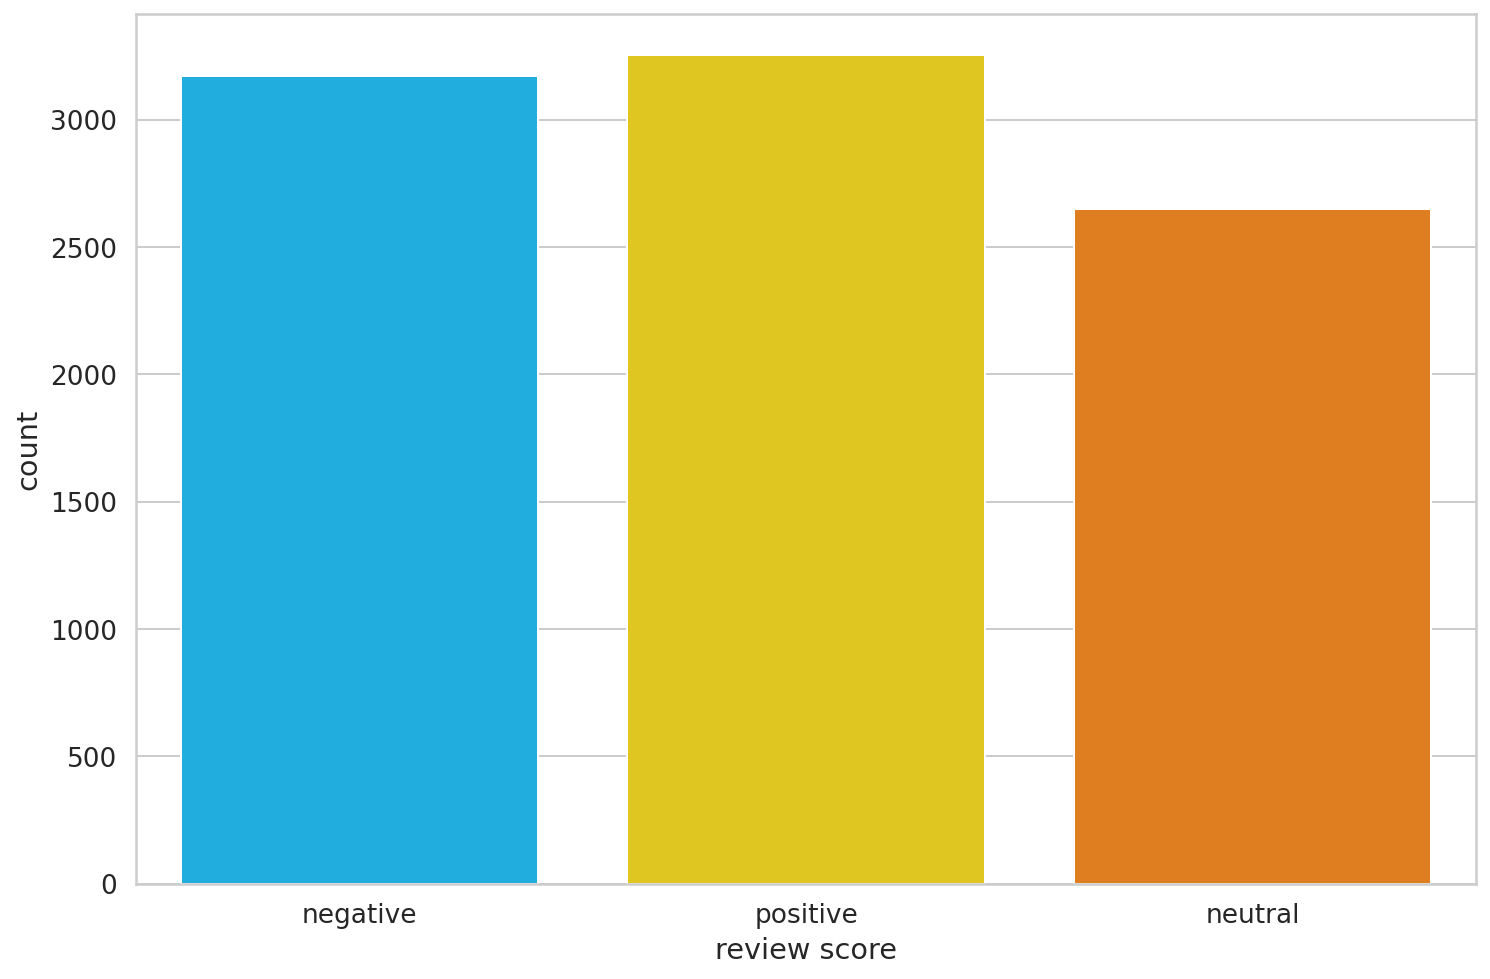

In [6]:
sns.countplot(df.sentiment)
plt.xlabel('review score');

We have a balanced dataset with respect to reviews (as we scraped it in a balanced way)

In [7]:
class_names = ['negative', 'positive', 'neutral']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


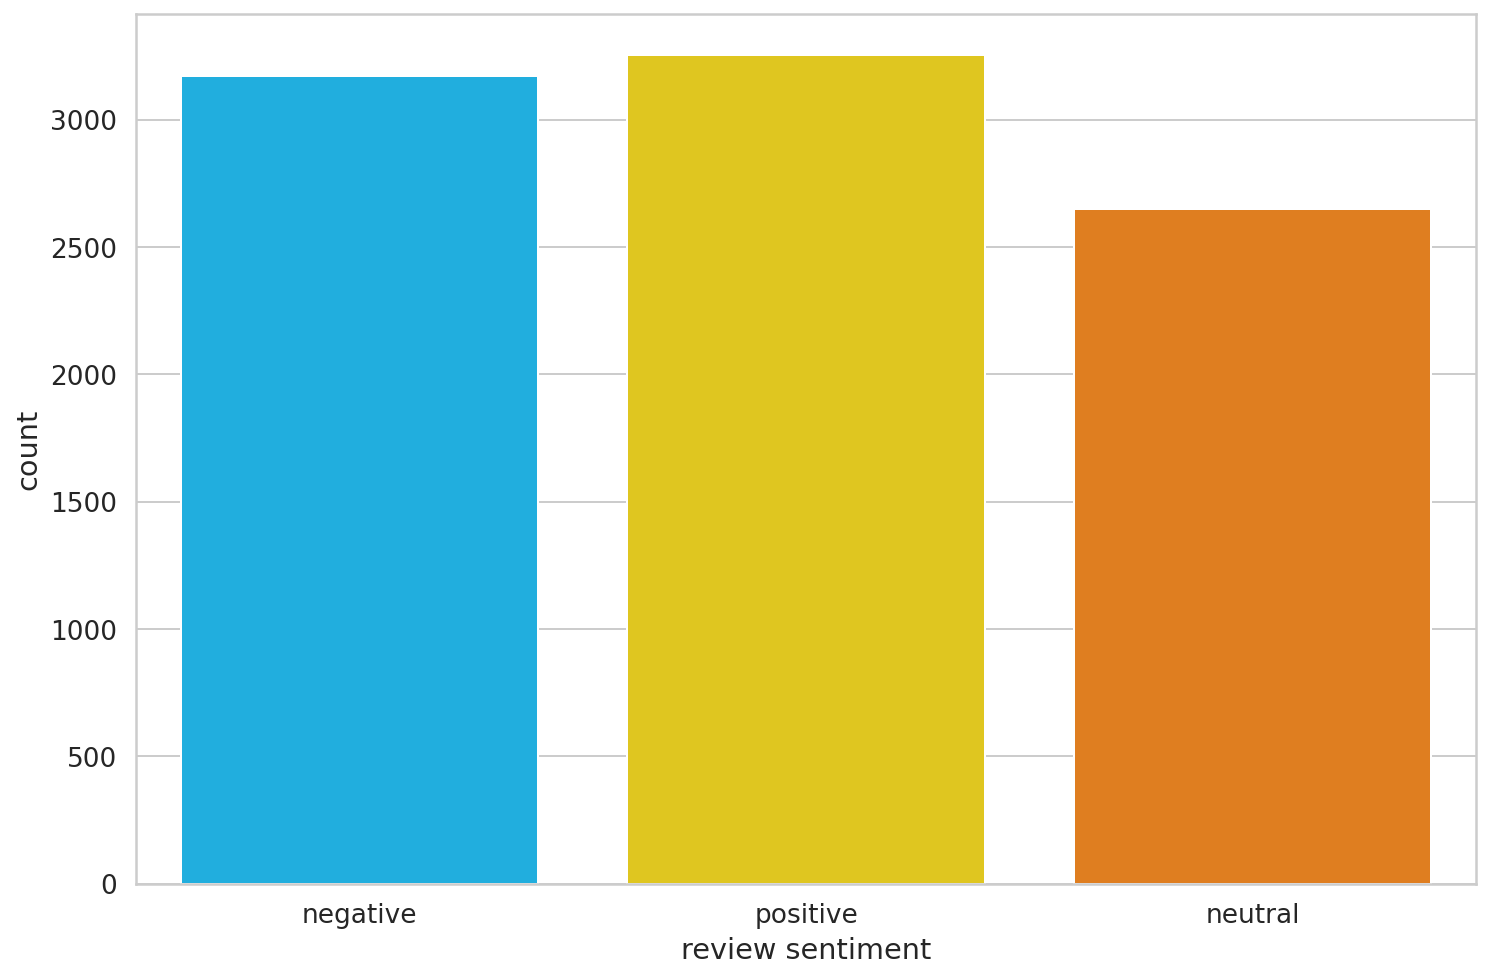

In [8]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

# Data Preprocessing
Machine Learning models don't work with raw text. We need to convert text to numbers (of some sort). BERT requires even more attention. Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides a wide variety of Transformer models (including BERT). It also includes prebuilt tokenizers that solves most of the load required for pre-processing

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Let's load a pre-trained BertTokenizer:

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

The requirements of special tokens which indicate seperation between sentences is taken care by the tokenizer provided by the huggingface. BERT was trained for question and answering task but we are using it to train with a sequence of sentences as input. We require sequences of equal length which is done by padding tokens of zero meaning without loss of generality to the end of sentences.

We also need to pass attention mask which is basically passing a value of 1 to all the tokens which have meaning and 0 to padding tokens.

## We'll use this simple text to understand the tokenization process:

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])

In [19]:
df

,review,sentiment
0,लोग वतन तक खा जाते हैं इसका इसे यकीन नहींमान ज...,0
1,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,0
2,ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है,0
3,यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...,0
4,अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...,0
...,...,...
9072,RT @aajtak: #Mojo बजरंग बली का सबसे विशालकाय र...,1
9073,RT @aajtak: कहां अचानक स्कूल में पड़ा मंत्री क...,1
9074,RT @aajtak: #MoJo सुनिए कुलभूषण की दर्दभरी आपब...,1
9075,RT @aajtak: लव जेहाद के नाम पर क्या उत्तर प्रद...,1


In [20]:
sample_txt = 'Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.'
#sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [21]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Sentence: {sample_txt}')
print(f'\n  Tokens: {tokens}')
print(f'\n  Token IDs: {token_ids}')   # Each token has a an unique ID for the model to unserstand what we are referring to.

  Sentence: Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.

  Tokens: ['Best', 'place', 'that', 'I', 'have', 'visited', '?', 'Iceland', 'was', 'the', 'most', 'beautiful', 'and', 'I', 'consider', 'myself', 'lucky', 'to', 'have', 'visited', 'Iceland', 'at', 'such', 'an', 'early', 'age', '.']

  Token IDs: [1798, 1282, 1115, 146, 1138, 3891, 136, 10271, 1108, 1103, 1211, 2712, 1105, 146, 4615, 1991, 6918, 1106, 1138, 3891, 10271, 1120, 1216, 1126, 1346, 1425, 119]


In [22]:
len(tokens)

27

## Special Tokens
[SEP] - marker for ending of a sentence

In [23]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [24]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [25]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:

In [26]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

## All of the above work can be done using the encode_plus() method

In [27]:
encoding_test = tokenizer.encode_plus(
  sample_txt,
  max_length=32,           # sequence length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors(use tf for tensorflow and keras)
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [28]:
encoding_test.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
print(' length of the first sequence is :  ', len(encoding_test['input_ids'][0]))
print('\n The input id\'s are : \n', encoding_test['input_ids'][0])
print('\n The attention mask generated is : ', encoding_test['attention_mask'][0])

 length of the first sequence is :   32

 The input id's are : 
 tensor([  101,  1798,  1282,  1115,   146,  1138,  3891,   136, 10271,  1108,
         1103,  1211,  2712,  1105,   146,  4615,  1991,  6918,  1106,  1138,
         3891, 10271,  1120,  1216,  1126,  1346,  1425,   119,   102,     0,
            0,     0])

 The attention mask generated is :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0])


We can inverse the tokenization to have a look at the special tokens:

In [30]:
tokenizer.convert_ids_to_tokens(encoding_test['input_ids'].flatten())

['[CLS]',
 'Best',
 'place',
 'that',
 'I',
 'have',
 'visited',
 '?',
 'Iceland',
 'was',
 'the',
 'most',
 'beautiful',
 'and',
 'I',
 'consider',
 'myself',
 'lucky',
 'to',
 'have',
 'visited',
 'Iceland',
 'at',
 'such',
 'an',
 'early',
 'age',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length

Check if there are any nan in the content column

In [31]:
df.loc[df.sentiment.isnull()]

,review,sentiment


In [32]:
df = df[df['review'].notna()]
df.head()

,review,sentiment
0,लोग वतन तक खा जाते हैं इसका इसे यकीन नहींमान ज...,0
1,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,0
2,ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है,0
3,यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...,0
4,अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...,0


BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [33]:
token_lens = []
for text in df.review:
    tokens_df = tokenizer.encode(text, max_length=512)   # Max possible length for the BERT model.
    token_lens.append(len(tokens_df))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


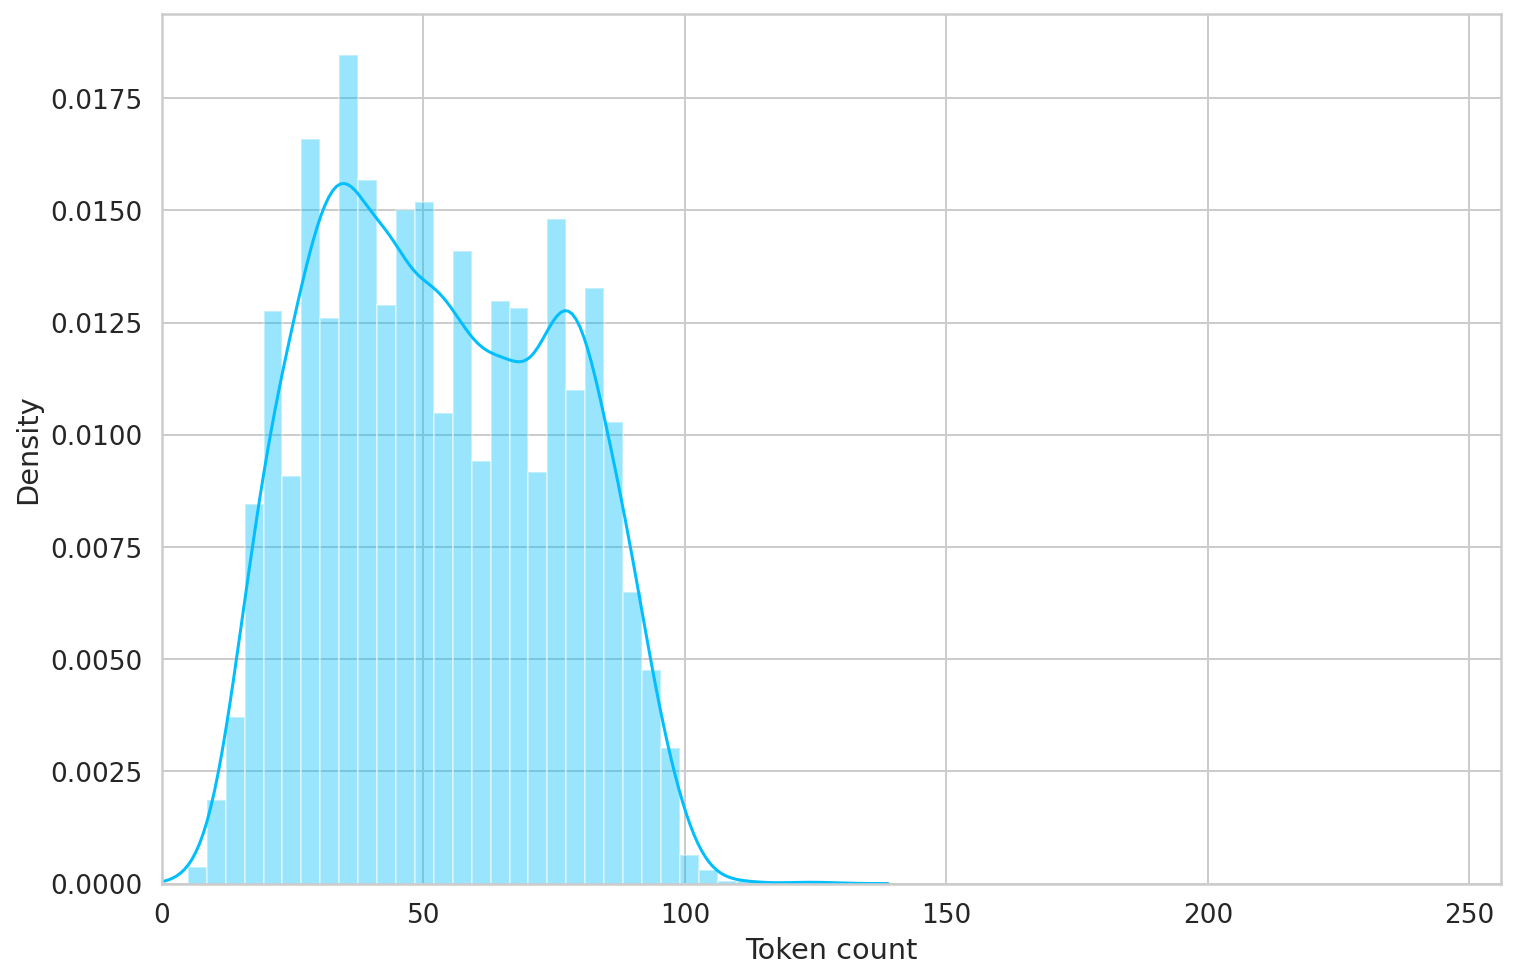

In [34]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [35]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's use the same class:

In [36]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews         # Reviews is content column.
    self.targets = targets         # Target is the sentiment column.
    self.tokenizer = tokenizer     # Tokenizer is the BERT_Tokanizer.
    self.max_len = max_len         # max_length of each sequence.
  
  def __len__(self):
    return len(self.reviews)       # Len of each review.
  
  def __getitem__(self, item):
    review = str(self.reviews[item])   # returns the string of reviews at the index = 'items'
    target = self.targets[item]        # returns the string of targets at the index = 'items'

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,                                   
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)            # dictionary containing all the features is returned.
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

# Splitting into train and validation sets

In [37]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [38]:
df_train.shape, df_val.shape, df_test.shape

((7261, 2), (908, 2), (908, 2))

## Create data loaders for to feed as input to our model. The below function does that.

In [39]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.values,
    targets=df.sentiment.values,
    tokenizer=tokenizer,
    max_len=max_len
  )                                  # Dataset would be created which can be used to create and return dataloader.

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4
  )

In [40]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [41]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 160])
torch.Size([8, 160])
torch.Size([8])


# Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task we might use "BertForSequenceClassification", "BertForQuestionAnswering" or something else.

We'll use the basic BertModel and build our sentiment classifier on top of it. Let's load the model:

In [43]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
model_test = bert_model(
  input_ids=encoding_test['input_ids'], 
  attention_mask=encoding_test['attention_mask']
)
model_test.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

The "last_hidden_state" is a sequence of hidden states of the last layer of the model. Obtaining the "pooled_output" is done by applying the BertPooler which basically applies the tanh function to pool all the outputs.

In [45]:
last_hidden_state=model_test['last_hidden_state']
pooled_output=model_test['pooler_output']

In [46]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence) and 768 is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [47]:
bert_model.config.hidden_size

768

We can think of the pooled_output as a summary of the content, according to BERT. Let's look at the shape of the output:

In [48]:
pooled_output.shape

torch.Size([1, 768])

We can use all this knowledge to create a sentiment classifier that uses the BERT model:

In [49]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)                                 ## For regularization with dropout probability 0.3.
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) ## append an Output fully connected layer representing the number of classes
  
  def forward(self, input_ids, attention_mask):
    returned = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

The classifier delegates most of the work to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. We're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Create an instance and move it to the GPU:

In [50]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data created above using dataloader to the GPU:

In [51]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 160])
torch.Size([8, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the output obtained from the output layer:

In [52]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2217, 0.4359, 0.3423],
        [0.2834, 0.3109, 0.4057],
        [0.4148, 0.2203, 0.3649],
        [0.1942, 0.3924, 0.4135],
        [0.5987, 0.1818, 0.2195],
        [0.2575, 0.3481, 0.3944],
        [0.2788, 0.3475, 0.3737],
        [0.3698, 0.2398, 0.3904]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Training the model

To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [53]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS    # Number of batches * Epochs (Required for the scheduler.)
 
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,     # Recommended in the BERT paper.
  num_training_steps=total_steps  
)

loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

Except for the number of epochs recommendation We'll stick with the rest. Increasing the batch size reduces the training time significantly, but gives lower accuracy.

# Helper function for training our model for one epoch:

In [54]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()    # To make sure that the droupout and normalization is enabled during the training.

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    max_prob, preds = torch.max(outputs, dim=1)    # Returns 2 tensors, one with max_probability and another with the respective predicted label.
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()     # Back_Propogation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Recommended by the BERT paper to clip the gradients to avoid exploding gradients.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)     # Return the mean loss and the ratio of correct predictions.

Training the model is similar to training a deep neural network, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm

# Helper function to evaluate the model on a given data loader:

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()        # To make sure that the droupout and normalization is disabled during the training.

  losses = []
  correct_predictions = 0

  with torch.no_grad():        # Back propogation is not required. Torch would perform faster. 
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      max_prob, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using these two helper functions, we can write our training loop. We'll also store the training history:

In [56]:
%%time

history = defaultdict(list)          # Similar to Keras library saves history
best_accuracy = 0                    

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.0658889681035202 accuracy 0.41165128770141857
Val   loss 1.116942282308612 accuracy 0.3513215859030837

Epoch 2/10
----------
Train loss 0.8894132468275037 accuracy 0.5172841206445393
Val   loss 0.7382492219146929 accuracy 0.6266519823788547

Epoch 3/10
----------
Train loss 0.7486123030242153 accuracy 0.6017077537529266
Val   loss 0.7579000105983332 accuracy 0.5660792951541851

Epoch 4/10
----------
Train loss 0.712187299283328 accuracy 0.6157554055915163
Val   loss 0.7074078687450343 accuracy 0.5792951541850221

Epoch 5/10
----------
Train loss 0.6524612270952059 accuracy 0.6383418261947391
Val   loss 0.6287077922831502 accuracy 0.656387665198238

Epoch 6/10
----------
Train loss 0.5939313178217358 accuracy 0.6541798650323647
Val   loss 0.6219617209413595 accuracy 0.6640969162995596

Epoch 7/10
----------
Train loss 0.5548460197795002 accuracy 0.6793830050957169
Val   loss 0.5640319290391186 accuracy 0.6751101321585904

Epoch 8/10
----------
Train loss 0.5160809393094171

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

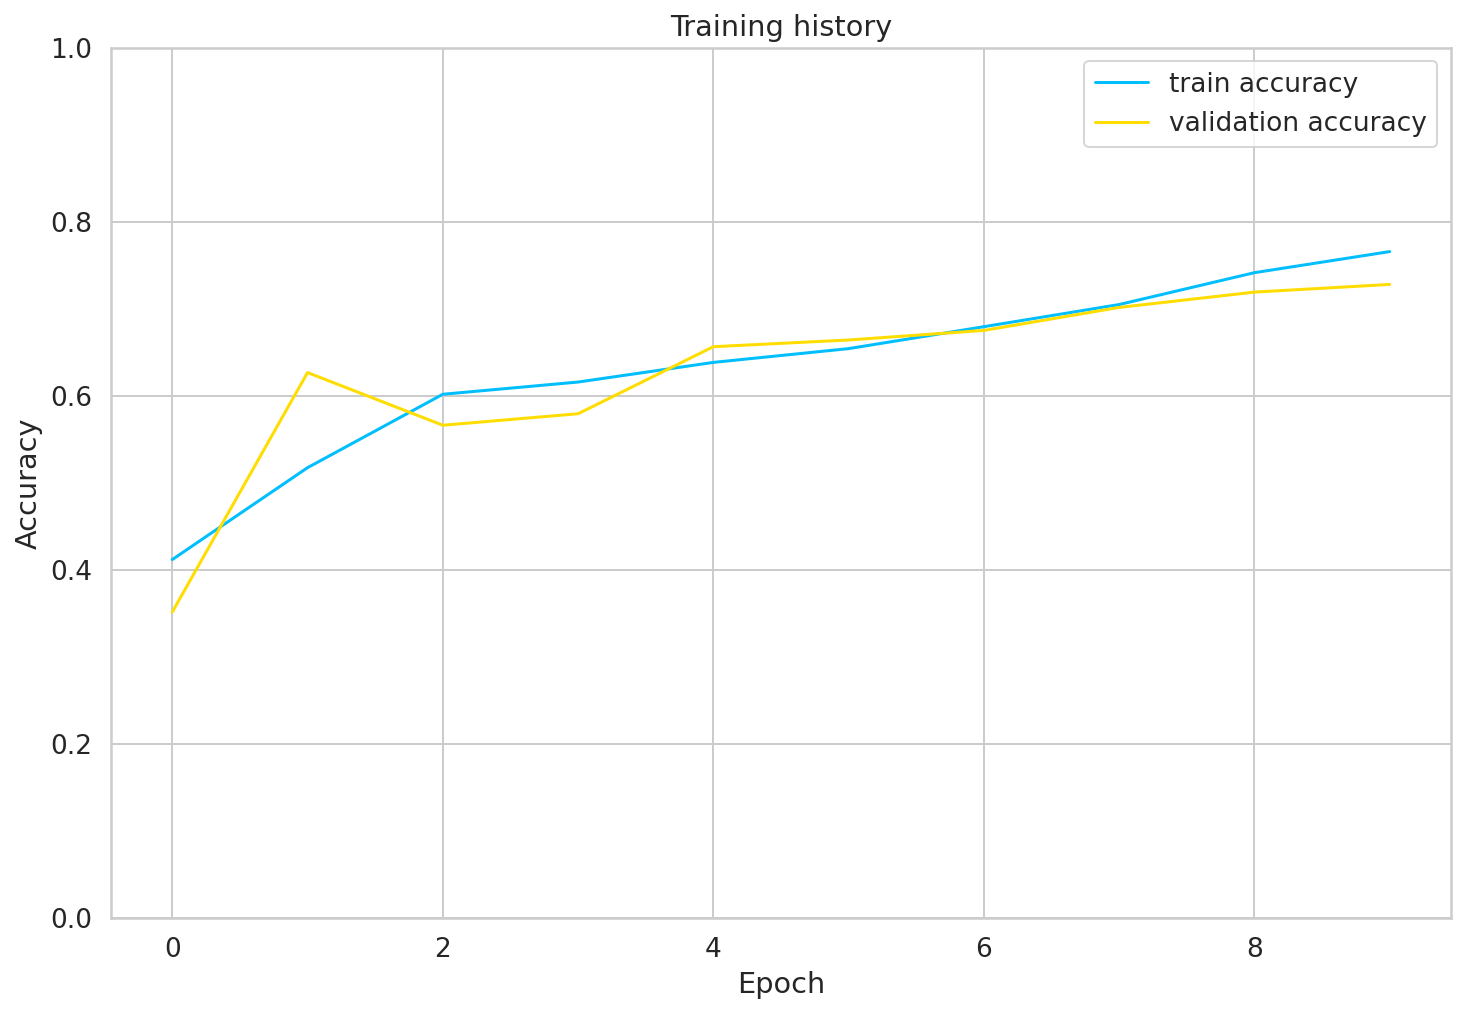

In [57]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [58]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.7367841409691631

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [60]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [61]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's have a look at the classification report

In [62]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.64      0.64      0.64       321
    positive       0.99      0.93      0.96       283
     neutral       0.63      0.65      0.64       304

    accuracy                           0.74       908
   macro avg       0.75      0.74      0.75       908
weighted avg       0.74      0.74      0.74       908



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

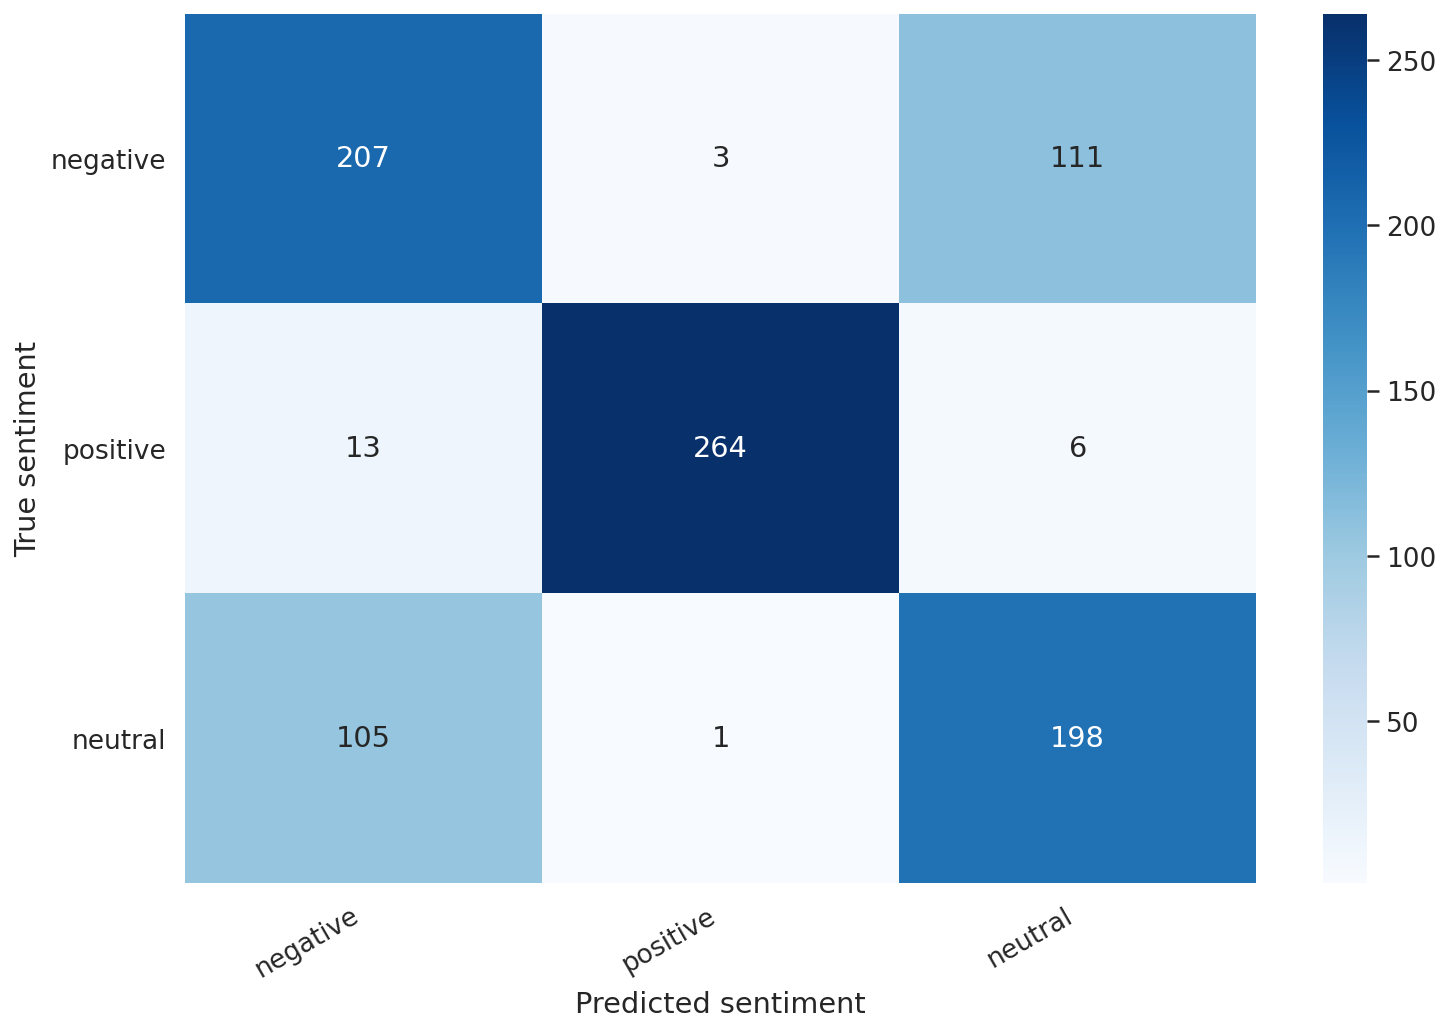

In [63]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [64]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [65]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

टाटा मोटर्स ने गुरुवार को अपनी क्रॉसओवर व्हीकल आरिया का उन्नत संस्करण
लांच किया है।

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

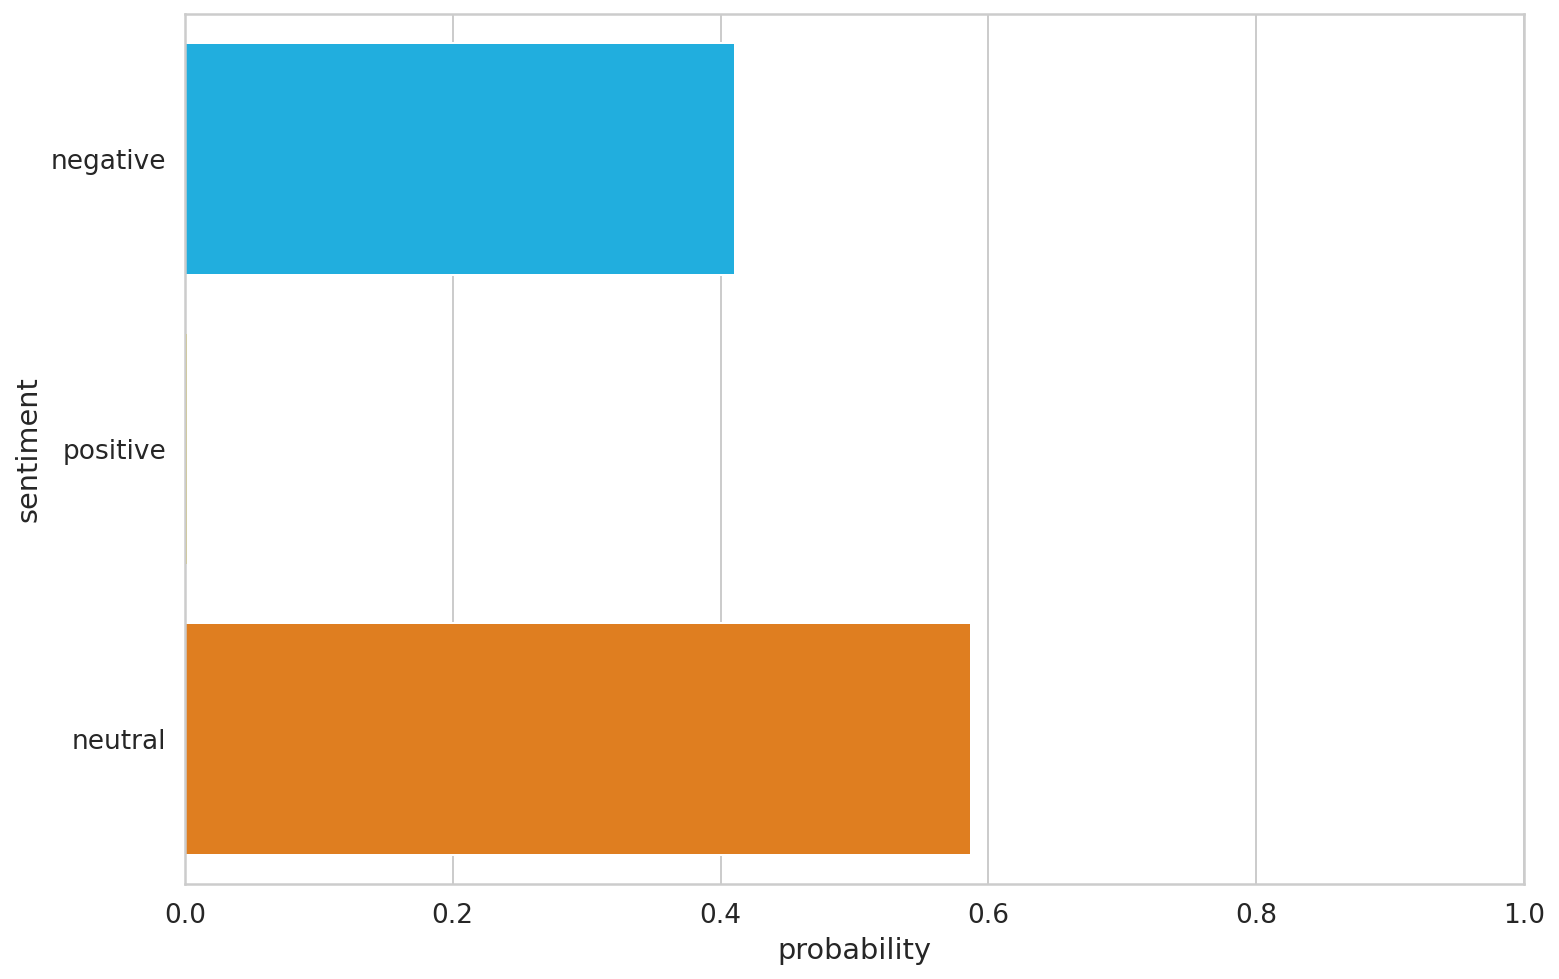

In [66]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [112]:
review_text = "देश में हो रहा हाहाकार हर जगह है भ्रष्टाचार इस देश का आम आदमी बिक रहा सरे बाजार जय हो जय हो खंग्रेस सरकार"

#review_text = "अगर आप इस फिल्म को देखने जा रहे हैं तो सबसे पहले तो आप यह जान लीजिए कि बेशक इस फिल्म के साथ प्रडूयसर कुमार मंगत, डायरेक्टर अश्विनी धीर के नाम के साथ परेश रावल का नाम भी जुड़ा हो लेकिन कुछ साल पहले आई फिल्म 'अतिथि तुम कब जाओगे' से इस फिल्म का कुछ लेना-देना नहीं है। यूं तो इस फिल्म के क्लाइमैक्स में आपको पिछली फिल्म के हीरो अजय देवगन भी नजर आएंगे लेकिन इन दोनों फिल्मों में सबसे बड़ा फर्क यह है कि इस बार चाचा जी मुंबई की किसी सोसाइटी की बजाय अपने एक अनजान रिश्तेदार के यहां लंदन जा पहुचे हैं और इस बार चाचा जी के साथ चाची जी भी हैं। दूसरी ओर, 'गेस्ट इन लंदन' पिछली फिल्म से टोटली अलग है। इंटरवल से पहले डायरेक्टर ने अपनी ओर से आपको हंसाने की हर मुमकिन कोशिश की है लेकिन इसमें ज्यादा कामयाब नहीं हो पाए तो इंटरवल के बाद क्लाइमैक्स में फिल्म की कहानी में कुछ ऐसा टर्न आता है कि आपकी आखें नम जाती हैं। वैसे, कुमार मंगत अपनी इस फिल्म को भी पिछली फिल्म के सीक्वल के नाम से ही बनाना चाहते थे लेकिन पिछली फिल्म की प्रॉडक्शन कंपनी से कुछ विवाद के चलते बात नहीं बन पाई तो मंगत अपने अतिथि को गेस्ट का नाम दिया तो मुंबई की बजाय गेस्ट के साथ लंदन पहुंच गए। कहानी: लंदन में रहने वाले आर्यन ग्रोवर (कार्तिक आर्यन) का वर्क वीज़ा खत्म होने वाला है और उसे न चाहते हुए भी वर्क वीज़ा खत्म होने के बाद भारत जाना ही होगा। ऐसे में उसके ऑफिस के कुछ साथी सलाह देते हैं कि अगर वह किसी ब्रिटिश मूल की लड़की के साथ डील करके मैरिज कर ले तो उसे लंदन रहने की स्थाई वीजा आसानी से मिल सकता है। आर्यन को यह आइडिया पसंद आता है और वह लंदन में अपनी फ्रेंड्स के साथ रह रहीं ब्रिटिश मूल की अनाया पटेल ( कृति खरबंदा) के साथ मिलकर नकली शादी करने का प्लान बनाता है। दोनों के बीच एक सीक्रेट डील होती है जिसके मुताबिक नकली शादी होने तक अनाया उसी के साथ रहेगी बस इसके अलावा इनके बीच और कोई रिश्ता नहीं होगा। इसी बीच आर्यन को खबर मिलती है कि इंडिया से उसके चाचा (परेश रावल) और चाची (तनवी आजमी) कुछ दिन उनके साथ रहने के लिए आ रहे हैं। वैसे, आर्यन ने चाचा जी को देखा तक नहीं है बस उसके पास अपने किसी रिश्तेदार का फोन आता है कि उसके पड़ोसी लंदन आ रहे हैं, कुछ दिन उसके घर मेहमान बनकर रहेंगे। अनाया से शादी की डील के होने के बाद अनाया भी कार्तिक के घर में ही रहती है। ऐसे में अचानक इसी घर में चाचा और चाची जी की एंट्री के बाद क्या कोहराम मचता है, यह मजेदार है। फिल्म में परेश रावल और तनवी आजमी दोनों की ऐक्टिंग का जवाब नहीं है। इन दोनों के बीच गजब की ऑनस्क्रीन केमिस्ट्री का इस फिल्म की सबसे बड़ी यूएसपी है। वहीं चाचा जी एकबार फिर पिछली फिल्म के चाचा जी की याद दिलाते हैं। कार्तिक आर्यन और कीर्ति खरबंदा की जोड़ी क्यूट और फ्रेश लगी तो दोनों अपने-अपने किरदार में फिट भी नजर आए। डायरेक्टर अश्विनी धीर की इंटरवल से पहले फिल्म पर कहीं पकड़ नजर नहीं आती, ऐसा लगता है इंटरवल तक उनके पास कहने के लिए कुछ था ही नहीं, लेकिन आखिरी बीस मिनट में धीर फिल्म को ट्रैक पर लाने में कामयाब रहे। राघव सच्चर और अमित मिश्रा का संगीत कहानी और माहौल के मुताबिक है, खासकर फिल्म के दो गाने 'दारू विच प्यार' और 'फ्रेंकी तू सोणा नच दी' का फिल्मांकन अच्छा बन पड़ा है और जेनएक्स की कसौटी पर यह गाने फिट बैठ सकते हैं। अगर आप परेश रावल के पक्के फैन हैं तो गेस्ट से मिलने जाएं लेकिन इस बार अतिथि वाली बात नजर नहीं आएगी। "

# review_text = "बैनर : वीनस रेकॉर्डस, इरोज़ एंटरटेनमेंट, बाबा आर्टस लिमिटेड प्रोडक्शन निर्माता : गणेश जैन, गिरीश जैन, रतन जैन निर्देशक : प्रियदर्शन संगीत : प्रीतम चक्रवर्ती, आरडीबी, एड बॉयज़ कलाकार : अक्षय कुमार, कैटरीना कैफ, सुनील शेट्टी, परेश रावल, नेहा धूपिया, समीरा रेड्डी, अर्चना पूरनसिंह, चंकी पांडे, राजपाल यादव, असरानी, शक्ति कपूर, अदिती गोवित्रीकर, मनोज जोशी यू/ए * 2 घंटे 40 मिनट प्रियदर्शन की ज्यादातर हास्य फिल्मों में पात्र गरीब होते हैं और जल्दी से अमीर बनने के उनके सपने होते हैं। इन सपनों को पूरा करने के लिए वे ऐसा कदम उठाते हैं कि मुसीबतों में फँस जाते हैं और हास्यास्पद परिस्थितियाँ निर्मित होती हैं। क्लायमैक्स में सारे पात्र एक इकठ्ठा होकर भागते रहते हैं और फिल्म खत्म होती है। उनकी ताजा फिल्म ‘दे दना दन’ में भी यही सब है। नितिन (अक्षय कुमार) और राम (सुनील शेट्टी) अपने काम से खुश नहीं हैं। उनकी गर्लफ्रेंड्‍स (कैटरीना कैफ और समीरा रेड्डी) बेहद अमीर हैं। नितिन और राम जल्दी अमीर बनना चाहते हैं ताकि अपनी प्रेमिकाओं से शादी कर सके क्योंकि उन्हें चेतावनी मिल चुकी है कि यदि वे जल्दी धनवान नहीं बने तो उनकी प्रेमिकाओं की शादी किसी ओर से हो जाएगी। अमीर बनने के लिए नितिन, राम के साथ मिलकर अपनी मालकिन (अर्चना पूरनसिंह) के कुत्ते का अपहरण कर लेता है क्योंकि इस कुत्ते को उसकी मालकिन बेटे जैसा चाहती है। कुत्ते को उठाने के बाद नितिन और राम एक आलीशान होटल में छिप जाते हैं, लेकिन कुछ देर बाद स्थिति उनके नियंत्रण से बाहर हो जाती है। इसी होटल में राम की प्रेमिका की शादी हरबंस (परेश रावल) के बेटे (चंकी पांडे) से हो रही है। पूरी बारात होटल में ठहरी है। चाइनीज़ डॉन (असरानी), हत्यारा (जॉनी लीवर), वेटर (राजपाल यादव), पुलिस इंसपेक्टर (शरत सक्सेना), क्लब डांसर (नेहा धूपिया) जैसे कुछ और पात्र कहानी में जुड़ जाते हैं और शुरू हो जाता है गलतफहमियों का सिलसिला जो अंत में होटल में बाढ़ आने के बाद समाप्त होता है। दो दर्जन से अधिक कलाकारों की भीड़ फिल्म में जमा की गई है। छोटे से रोल में भी नामी कलाकार है। हर किरदार की अपनी कहानी है और इस कारण मुख्य कहानी के साथ-साथ कई कहानियाँ चलती रहती है। थोड़ी देर बाद किरदारों की तरह दर्शक भी कन्फ्यूज होने लगता है। शायद प्रियन यही चाहते हैं कि दर्शक कन्फ्यूज हो जाए और सामने चल रहे दृश्य का मजा ले और क्या हो रहा है, क्यों हो रहा है जैसी बातों में न पड़े। जो लोग दिमाग पर ज्यादा जोर नहीं डालना चाहते हैं उन्हें हँसने के कई मौके फिल्म उपलब्ध कराती है। अक्षय-अर्चना और जॉनी लीवर वाले कुछ दृश्य बेहतरीन बन पड़े हैं। प्रियदर्शन का निर्देशन रूटीन काम की तरह है। उनके पास नया देने के लिए कुछ नहीं है और उन्होंने अपने आपको दोहराया ही है। उन्होंने सिर्फ कॉमेडी पर फोकस किया है और रोमांस, इमोशन जैसी बातों को भूला दिया है। अक्षय-कैटरीना जैसी सफल जोड़ी का भी खास उपयोग नहीं किया गया। अक्षय और कैटरीना जैसे स्टार्स के साथ यह फिल्म न्याय नहीं करती है। इन दोनों स्टार्स के रोल देखकर उनके प्रशंसक खुश नहीं होंगे। इंटरवल के बाद तो अक्षय को एक अलमारी में बंद कर कुछ देर के लिए भूला दिया गया है। अभिनय की बात की जाए तो अक्षय कुमार, परेश रावल, नेहा धूपिया और जॉनी लीवर याद रहते हैं। फिल्म के अधिकतर कलाकारों ने लाउड एक्टिंग की है और चीख-चीखकर संवाद बोले हैं। एकाध गाना छोड़ दिया जाए तो प्रीतम का संगीत शोरगुल से भरा हुआ है। गानों की सिचुएशन भी ठीक से निर्मित नहीं की गई है और उन्हें ठूँस दिया गया है। हाल ही में प्रदर्शित ‘डू नॉट डिस्टर्ब’ की तरह इस फिल्म की भी आधे से ज्यादा शूटिंग एक होटल में की गई है। कुल मिलाकर ‘दे दना दन’ उन लोगों को थोड़ा-बहुत मनोरंजन कर सकती है, जो दिमाग पर जोर लगाए बिना कुछ देर हँसना चाहते हैं।"

We have to use the tokenizer to encode the text:

In [113]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's get the predictions from our model:

In [114]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: देश में हो रहा हाहाकार हर जगह है भ्रष्टाचार इस देश का आम आदमी बिक रहा सरे बाजार जय हो जय हो खंग्रेस सरकार
Sentiment  : negative
